In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch

from pytorch_wavelets import DTCWTForward, DTCWTInverse
from sklearn.model_selection import train_test_split
import random

from efficientnet_pytorch import EfficientNet
import pickle

import matplotlib.pyplot as plt
from scipy import fftpack

import os
from pathlib import Path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import Lambda


In [2]:

class EfficientNet_b0(nn.Module):

    def __init__(self,no_of_outputs_classes_for_your_dataset=20, batch_size = 54):
        """initialisation of the neural network using as a segmentation network
        the efficientnet_pytorch
        https://github.com/lukemelas/EfficientNet-PyTorch/blob/master/efficientnet_pytorch/model.py
        and add a few layers.

        Args:
            no_of_outputs_classes_for_your_dataset (int): depends on what we want to predict. Defaults to 2.
        """

        super(EfficientNet_b0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.lstm = nn.LSTM(1280,no_of_outputs_classes_for_your_dataset, batch_first=True)
        self.hidden_units = no_of_outputs_classes_for_your_dataset
        self.classifier_layer = nn.Sequential(
                nn.Linear(1281 , 512),
                nn.BatchNorm1d(512),
                nn.Dropout(0.2),
                nn.Linear(512 , 256),
                nn.Linear(256 , no_of_outputs_classes_for_your_dataset),

            )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)#do we want this as optimizer?
        self.mse = nn.MSELoss()
        self.lin1 = nn.Linear(1280 , no_of_outputs_classes_for_your_dataset)

    def forward(self, inputs):
        """pass forward through the network to compute the neural result we want

        Args:
            inputs (_type_): the image presented to the mices

        Returns:
            _type_: the V1 neural response
        """
        input = inputs.float()
        input = self.model.extract_features(input)
        input = self.model._avg_pooling(input)
        input = input.flatten(start_dim=1)
        input = self.model._dropout(input)
        
        h0 = torch.zeros( 1, self.hidden_units).requires_grad_()
        c0 = torch.zeros( 1, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(input, (h0, c0))

        return hn


    def forward_train(self, inputs):
        """pass forward through the network to compute the neural result we want

        Args:
            inputs (_type_): the image presented to the mices

        Returns:
            _type_: the V1 neural response
        """
       
        input = inputs.float()
        with torch.no_grad():
          input = self.model.extract_features(input)
          input = self.model._avg_pooling(input)
          input = input.flatten(start_dim=1)
          input = self.model._dropout(input)
        h0 = torch.zeros( 1, self.hidden_units).requires_grad_()
        c0 = torch.zeros( 1, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(input, (h0, c0))
        #x = self.lin1(inputs)
        return hn

    def backward(self, y_pred, y_exp):
        """the backward cahnge the weights of the network using the backpropagation
        algorithm and the chosen algorithm

        Args:
            y_pred (_type_): the result of the forward pass
            y_exp (_type_): the actual result we wish to have

        Returns:
            double: the loss of this backward pass (for this batch and epoch)
        """
        y_pred = y_pred.float()
        y_exp = y_exp.float()
        loss = self.mse(y_pred, y_exp)
    
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            self.optimizer.step()
        return loss


In [3]:
file = open('./dat_test', 'rb')
dat = pickle.load(file)
file.close()
dat = dat.sort_values('index').drop('index', axis = 1)

In [4]:
dat.head()

,count,950922041,950922122,950922146,950922174,950922208,950922234,950922258,950922286,950922329,...,950933907,950933924,950933960,950934028,950934044,950934181,950934229,950934268,950934286,950934304
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,
49432,34.0,5.0,0.0,2.0,2.0,0.0,5.0,1.0,3.0,7.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49433,52.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
49434,94.0,1.0,0.0,1.0,0.0,2.0,3.0,1.0,3.0,1.0,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
49435,36.0,0.0,0.0,1.0,0.0,0.0,7.0,2.0,5.0,1.0,...,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0
49436,40.0,3.0,1.0,1.0,1.0,3.0,2.0,5.0,4.0,1.0,...,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,2.0


In [5]:
"""train= dat.head(int(len(dat)*(0.8)))
test = dat.tail(int(len(dat)*(0.2)))
output_train = torch.tensor(train.drop(['count'],axis = 1).values)
output_test = torch.tensor(test.drop(['count'],axis = 1).values)"""
index = random.sample(range(0,239),int(239*0.8))
train= dat[dat['count'].isin(index)]
test = dat[-dat['count'].isin(index)]
output_train = torch.tensor(train.drop(['count'],axis = 1).values)
output_test = torch.tensor(test.drop(['count'],axis = 1).values)

In [6]:
test.head(5)

,count,950922041,950922122,950922146,950922174,950922208,950922234,950922258,950922286,950922329,...,950933907,950933924,950933960,950934028,950934044,950934181,950934229,950934268,950934286,950934304
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,
49437,81.0,2.0,0.0,4.0,1.0,4.0,5.0,4.0,7.0,2.0,...,0.0,0.0,11.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
49446,59.0,4.0,0.0,1.0,0.0,10.0,3.0,3.0,3.0,0.0,...,0.0,0.0,2.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0
49453,87.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,3.0,0.0,...,0.0,0.0,0.0,4.0,4.0,1.0,4.0,0.0,0.0,1.0
49457,59.0,1.0,0.0,1.0,0.0,7.0,2.0,3.0,8.0,4.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
49471,89.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def train_transf(y):
    res = []
    for i in [y-2,y-1,y]:
        if (train.index==i).any():
            res.append(train[train.index==i.tolist()].drop(['count'],axis = 1).values)
        else:
            res.append(np.zeros((train[train.index==y.tolist()].drop(['count'],axis = 1).values).shape))
    res = torch.from_numpy(np.array(res).astype(float)).squeeze(1)
    return res

def test_transf(y):
    res = []
    for i in [y-2,y-1,y]:
        if (test.index==i).any():
            res.append(test[test.index==i.tolist()].drop(['count'],axis = 1).values)
        else:
            res.append(np.zeros((test[test.index==y.tolist()].drop(['count'],axis = 1).values).shape))
    res = torch.from_numpy(np.array(res).astype(float)).squeeze(1)
    return res

In [8]:
transform = Lambda(lambda y: torch.cat((y,y,y),0).unsqueeze(0))
target_transform_train = Lambda(lambda y : train_transf(y))
target_transform_test = Lambda(lambda y : test_transf(y))
img_dir = './../data/images/image_'
img_label = train['count']
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.empty((1,3,224,224))
        
        for i in [idx-4,idx-3,idx-2,idx-1,idx]:
            if i>-1:
                im = read_image(self.img_dir+ str(self.img_labels.iloc[idx, 0])+'.png')
                
                if self.transform:
                    im = self.transform(im)
               
                image = torch.cat((image, im), dim=0)
            else:
                im = torch.empty((1,224,224))
                if self.transform:
                    im = self.transform(im)
                image = torch.cat((image, im), dim=0)
        image = image[1:,:,:,:]
        
       
        label = self.img_labels.iloc[idx, 1]
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(CustomImageDataset(train.reset_index()[['count','stimulus_presentation_id']],img_dir,transform,target_transform_train), batch_size=1, shuffle=True)
test_dataloader = DataLoader(CustomImageDataset(test.dropna().reset_index()[['count','stimulus_presentation_id']],img_dir,transform,target_transform_test), batch_size=1, shuffle=True)

In [10]:
temp = iter(test_dataloader)
train_features, train_labels = next(temp)
train_features, train_labels = next(temp)
print(train_labels.shape)

torch.Size([1, 3, 259])


Feature batch shape: torch.Size([1, 5, 3, 224, 224])
Labels batch shape: torch.Size([1, 3, 259])


TypeError: Invalid shape (3, 224, 224) for image data

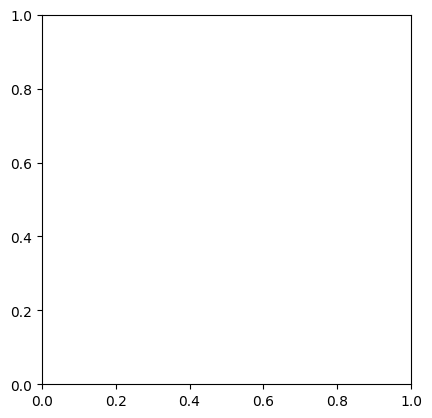

In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0:1,:,:].squeeze(),cmap = 'gray')
plt.show()
print(f"Label: {label}")


In [12]:
batch_size = 54
Eff=EfficientNet_b0(train_labels.size(-1),5).to(device)
epochs = 10
l = []
Eff.train()

for epoch in range(epochs):
    b = 0
    print(epoch)
    loss_epoch = []
    #iterr = iter(train_dataloader)
    for iterr in iter(train_dataloader):
        true_in,true_out = iterr
        b += 1
        torch.no_grad()
        true_input = true_in.squeeze(0).nan_to_num(-1).to(device).float()
        true_output = true_out.squeeze().to(device)
        predicted_output = Eff.forward_train(true_input).squeeze(0)
        if not torch.isnan(predicted_output).any():
            loss= Eff.backward(predicted_output,true_output[-1,:])
            loss_epoch.append(float(loss))
            if b%200 == 0:
                print(loss)
        else:
            predicted_output = Eff.forward_train(true_input[1:,:]).squeeze(0)
            if not torch.isnan(predicted_output).any():
                loss= Eff.backward(predicted_output,true_output[-1,:])
                loss_epoch.append(float(loss))
                if b%200 == 0:
                    print(loss)
            else:
                predicted_output = Eff.forward_train(true_input[2:,:]).squeeze(0)
                if not torch.isnan(predicted_output).any():
                    loss= Eff.backward(predicted_output,true_output[-1,:])
                    loss_epoch.append(float(loss))
                    if b%200 == 0:
                        print(loss)
                
    l.append(loss_epoch)


Loaded pretrained weights for efficientnet-b0
0
tensor(9.7948, grad_fn=<MseLossBackward0>)
tensor(4.0870, grad_fn=<MseLossBackward0>)
tensor(15.9664, grad_fn=<MseLossBackward0>)
tensor(13.5606, grad_fn=<MseLossBackward0>)
tensor(12.3094, grad_fn=<MseLossBackward0>)
tensor(15.6740, grad_fn=<MseLossBackward0>)
tensor(7.2445, grad_fn=<MseLossBackward0>)
tensor(14.2701, grad_fn=<MseLossBackward0>)
tensor(12.4263, grad_fn=<MseLossBackward0>)
tensor(19.1072, grad_fn=<MseLossBackward0>)
tensor(17.9679, grad_fn=<MseLossBackward0>)
tensor(7.6589, grad_fn=<MseLossBackward0>)
tensor(13.0608, grad_fn=<MseLossBackward0>)
tensor(16.1630, grad_fn=<MseLossBackward0>)
tensor(8.4992, grad_fn=<MseLossBackward0>)
tensor(6.0806, grad_fn=<MseLossBackward0>)
tensor(17.5087, grad_fn=<MseLossBackward0>)
tensor(10.3546, grad_fn=<MseLossBackward0>)
tensor(5.7608, grad_fn=<MseLossBackward0>)
tensor(17.1329, grad_fn=<MseLossBackward0>)
tensor(13.2601, grad_fn=<MseLossBackward0>)
tensor(12.5424, grad_fn=<MseLossBac

In [33]:
file = open('./LSTM_long', 'wb')
pickle.dump(Eff, file)
file.close()

In [12]:
file = open('./LSTM_long', 'rb')
Eff = pickle.load(file)
file.close()

In [12]:
dat.shape

(10432, 260)

In [14]:
from sklearn.metrics import r2_score
test_loss = []
result = torch.empty(0,train_labels.size(-1)).to(device)
loss = nn.MSELoss()
Eff.train()
for true_input_test,true_output_test in test_dataloader:
    true_input_test = true_input_test.nan_to_num().squeeze(0).to(device).float()
    true_output_test = true_output_test.squeeze().to(device)[:1,:]
    predicted_output_test = Eff.forward_train(true_input_test)
    l = float(loss(predicted_output_test,true_output_test))
    if l != l:
        print('nan_detected' ,type(true_input_test))

        if torch.isnan(true_input_test).any() :
            print('input', true_input_test.shape, true_input_test)

        elif torch.isnan(true_output_test).any():
            print('output', true_output_test.shape, true_output_test)
    test_loss.append(l)
    
    result = torch.cat((result,predicted_output_test))
print(test_loss)
result = pd.DataFrame(result.cpu().detach().numpy())

print(sum(test_loss)/len(test_loss))
r2_score(test.dropna().drop(['count'], axis=1).T,result.loc[:, result.columns != 'count'].T)

[16.21515051503966, 0.781411713143546, 0.7863511635774942, 0.786380997559995, 0.7910069963589172, 0.7914804417579477, 0.7931663144485378, 0.7796479508986833, 9.820410629894534, 0.7814246683671925, 0.7846186730952432, 0.7827335322374918, 0.7794834191196123, 0.7886905658445792, 0.7927164910772988, 7.000903216331802, 12.613015824668654, 0.7890875466759041, 0.7845329134836608, 0.780218879039408, 0.7918722315290152, 10.88216323305546, 0.7843438082822921, 14.688066558461825, 0.787677609719036, 0.7849934397265736, 0.789694644800537, 0.7885820820988236, 0.7893388927612538, 0.7867628541512945, 0.7857613475106978, 0.7821079381903824, 10.614768398265142, 0.7809445502633019, 0.789949397919356, 0.788189669465107, 0.7888182002336986, 0.7872413708136257, 0.7801466283768044, 0.7848895630765763, 0.7937444480749507, 0.7828976026598612, 0.7921672170390406, 0.7919674709686122, 0.7777693998863547, 0.7827975251878871, 0.791709890841628, 0.784550391260872, 0.7949371017429412, 0.7828032106882487, 0.7875940432

-0.13859141075276507

In [15]:
r2_score(test.dropna().drop(['count'], axis=1),result.loc[:, result.columns != 'count'])

-0.49097731553359863

In [34]:
pd.set_option('display.max_columns', None)
train.head(10)

,count,950922041,950922122,950922146,950922174,950922208,950922234,950922258,950922286,950922329,950922351,950922368,950922383,950922466,950922494,950922551,950922576,950922600,950922641,950922659,950922684,950922706,950922725,950922745,950922781,950922841,950922883,950922896,950922929,950922961,950922994,950923011,950923049,950923089,950923121,950923165,950923181,950923217,950923236,950923254,950923348,950923365,950923405,950923464,950923485,950923606,950923669,950923690,950923730,950923754,950923859,950923880,950923897,950923914,950923939,950923958,950923976,950924072,950924089,950924107,950924147,950924173,950924212,950924231,950924272,950924372,950924413,950924434,950924452,950924500,950924519,950924598,950924635,950924693,950924735,950924753,950924800,950924845,950924883,950924899,950925057,950925092,950925112,950925132,950925149,950925166,950925187,950925212,950925267,950925332,950925368,950925383,950925400,950925438,950925455,950925508,950925555,950925626,950925644,950925664,950925707,950925730,950925749,950925786,950925850,950925902,950925925,950925950,950925967,950925983,950926001,950926055,950926095,950926208,950926709,950926787,950926805,950926867,950926886,950926928,950927002,950927024,950927046,950927066,950927229,950927323,950927341,950927745,950927775,950928113,950928160,950928179,950928198,950928255,950928387,950928423,950928440,950928461,950928497,950928518,950928536,950928588,950928686,950928759,950928795,950928855,950928873,950928891,950928911,950928976,950928991,950929009,950929067,950929083,950929101,950929134,950929153,950929171,950929188,950929206,950929227,950929245,950929286,950929377,950929400,950929420,950929495,950929514,950929531,950929570,950929592,950929663,950929697,950929750,950929787,950929804,950929824,950929882,950930105,950930145,950930215,950930237,950930276,950930340,950930358,950930375,950930392,950930407,950930423,950930437,950930454,950930522,950930795,950930866,950930888,950930964,950930985,950931004,950931043,950931118,950931164,950931181,950931236,950931254,950931272,950931315,950931363,950931423,950931458,950931517,950931533,950931565,950931581,950931617,950931656,950931727,950931751,950931770,950931805,950931853,950931878,950931899,950931959,950932032,950932087,950932102,950932445,950932563,950932578,950932696,950932820,950932888,950932943,950932963,950932980,950933012,950933040,950933057,950933173,950933208,950933226,950933426,950933536,950933555,950933606,950933660,950933698,950933732,950933840,950933890,950933907,950933924,950933960,950934028,950934044,950934181,950934229,950934268,950934286,950934304
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49432,34.0,5.0,0.0,2.0,2.0,0.0,5.0,1.0,3.0,7.0,7.0,2.0,5.0,1.0,10.0,4.0,9.0,6.0,0.0,0.0,2.0,9.0,2.0,2.0,1.0,1.0,3.0,7.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,3.0,10.0,8.0,8.0,8.0,1.0,0.0,0.0,2.0,1.0,14.0,0.0,0.0,8.0,2.0,2.0,7.0,0.0,3.0,6.0,7.0,1.0,7.0,7.0,5.0,6.0,1.0,4.0,5.0,8.0,5.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,9.0,0.0,1.0,1.0,1.0,5.0,2.0,3.0,3.0,2.0,4.0,0.0,7.0,4.0,2.0,2.0,1.0,4.0,1.0,2.0,2.0,3.0,9.0,1.0,1.0,2.0,1.0,6.0,7.0,1.0,0.0,5.0,2.0,0.0,3.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,7.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,2.0,5.0,5.0,0.0,9.0,0.0,6.0,5.0,8.0,0.0,0.0,0.0,3.0,5.0,0.0,4.0,9.0,0.0,0.0,5.0,2.0,0.0,32.0,0.0,2.0,4.0,3.0,3.0,2.0,2.0,1.0,14.0,2.0,4.0,22.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,23.0,0.0,5.0,0.0,1.0,2.0,1.0,36.0,0.0,16.0,5.0,1.0,21.0,8.0,12.0,3.0,0.0,14.0,4.0,3.0,1.0,5.0,0.0,1.0,0.0,9.0,1.0,6.0,8.0,8.0,3.0,14.0,6.0,0.0,1.0,0.0,8.0,1.0,1.0,6.0,10.0,4.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49433,52.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,7.0,1.

In [ ]:
r2_score(test.dropna().drop(['count'], axis=1).T,result.loc[:, result.columns != 'count'].T)

-0.12868274582174677

In [23]:
result.shape

(2086, 259)

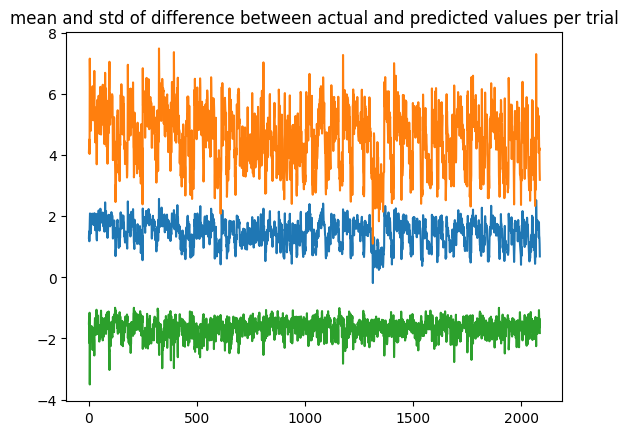

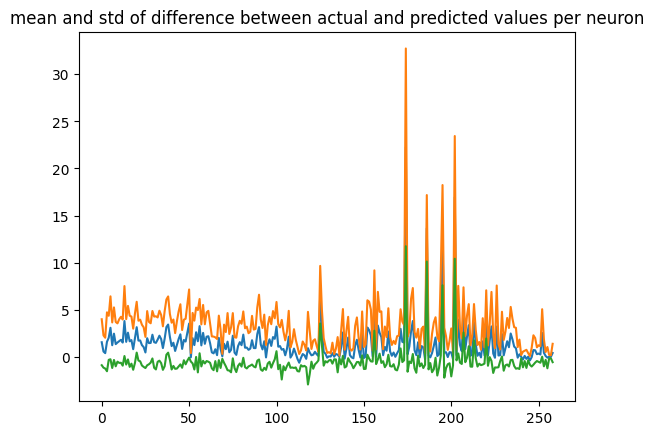

In [25]:
result['count']= test.dropna()['count'].values
temp1 = test.dropna().drop(['count'], axis=1)
temp1.columns = range(temp1.columns.size)
temp1.reset_index(inplace = True,drop=True)
temp2 = (temp1-result).drop( ['count'],axis =1)
plt.plot((temp1-result).T.describe().T['mean'] )
plt.plot((temp1-result).T.describe().T['mean'] +(temp1-result).T.describe().T['std'])
plt.plot((temp1-result).T.describe().T['mean'] -(temp1-result).T.describe().T['std'])
plt.title('mean and std of difference between actual and predicted values per trial')
plt.show()
plt.plot((temp2).describe().T['mean'] )
plt.plot((temp2).describe().T['mean'] +(temp2).describe().T['std'])
plt.plot((temp2).describe().T['mean'] -(temp2).describe().T['std'])
plt.title('mean and std of difference between actual and predicted values per neuron')
plt.show()

In [26]:
(temp1-result)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,count
0,-0.999909,-5.258204e-04,-0.999909,-0.999909,-0.999909,3.000091,-0.999909,2.000091,0.000091,4.000091,...,1.265990e-13,5.267128e-23,1.000091,0.000091,-0.002819,1.238494,-1.333224e-09,8.716640e-17,8.759658e-12,NaN
1,1.000091,-1.044189e-04,0.000117,1.000091,1.000091,4.000091,-0.999909,4.000091,4.000091,1.000091,...,1.207178e-15,6.901513e-25,0.000091,0.000091,-0.002008,0.238446,-2.352523e-09,4.606209e-17,1.000000e+00,NaN
2,0.000091,-1.927645e-06,-0.999909,-0.999909,3.000091,0.000091,1.000091,3.000091,-0.999909,1.000091,...,1.000000e+00,1.715642e-22,4.000091,-0.999909,-0.002136,0.238416,-4.180221e-11,2.965164e-21,1.278587e-11,NaN
3,0.000091,-3.140052e-03,1.000092,1.000091,1.000091,9.000091,0.000091,0.000091,-0.999909,0.000091,...,4.405154e-13,3.822113e-24,3.000091,-0.999909,-0.002100,3.238407,-4.840600e-08,5.954737e-16,1.558099e-10,NaN
4,0.000091,-2.824446e-02,-0.983022,1.000091,1.000091,-0.999909,-0.999909,2.000091,-0.999909,-0.999909,...,2.717514e-11,2.785282e-19,3.000091,2.000091,0.000002,3.238406,-1.112567e-07,8.267929e-11,1.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,2.000091,9.838054e-01,4.004947,2.000091,5.000091,3.000091,11.000091,3.000091,2.000091,2.000091,...,3.547460e-12,1.000000e+00,8.000091,1.004946,-0.002832,0.238424,-4.844228e-09,7.444158e-17,2.000000e+00,NaN
2082,0.000091,-1.488277e-03,5.000091,-0.999909,2.000091,13.000091,0.000091,10.000091,1.000091,1.000091,...,2.707684e-13,1.000000e+00,2.000091,0.000091,-0.012221,-0.761592,-7.543166e-09,-1.216935e-15,4.082668e-10,NaN
2083,0.000091,5.571503e-01,13.000114,-0.999909,-0.999909,2.000091,0.000091,2.000091,4.000091,1.000091,...,2.733221e-11,1.000000e+00,7.000091,2.000091,-0.139116,-0.761592,-5.272522e-08,3.805501e-13,2.922015e-09,NaN
2084,1.000091,-2.505000e-01,2.000092,6.000091,0.000091,4.000091,1.000091,3.000091,0.000091,0.000091,...,1.000000e+00,1.000000e+00,1.000091,2.000091,-0.009867,-0.761594,-7.281224e-08,-1.981003e-12,7.374986e-10,NaN


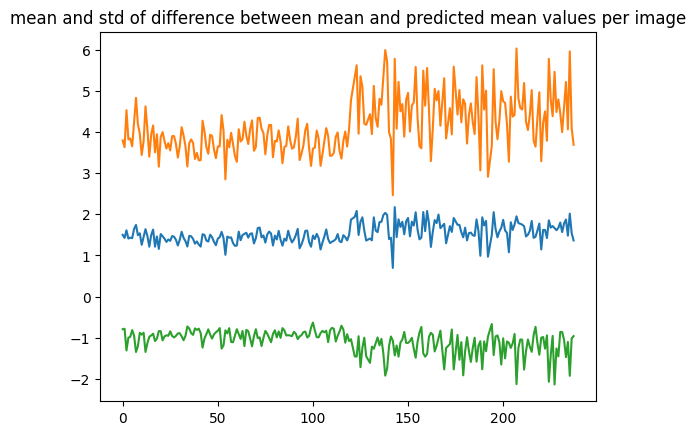

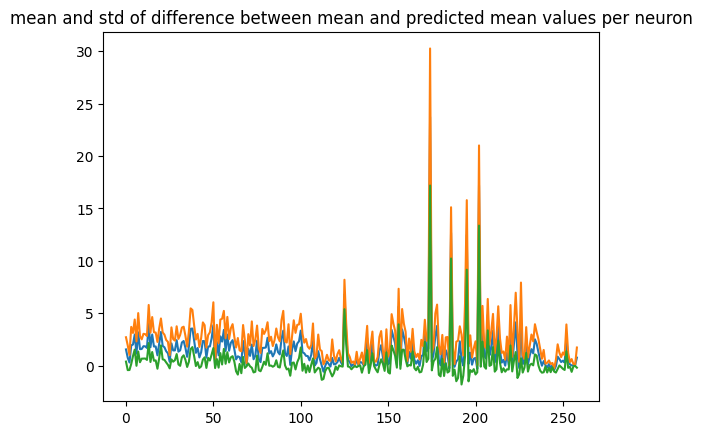

In [27]:
result['count']= test.dropna()['count'].values
res = result.groupby('count').mean()
temp = test.dropna().groupby('count').mean()
temp.columns = range(temp.columns.size)
plt.plot((temp-res).T.describe().T['mean'] )
plt.plot((temp-res).T.describe().T['mean'] +(temp-res).T.describe().T['std'])
plt.plot((temp-res).T.describe().T['mean'] -(temp-res).T.describe().T['std'])
plt.title('mean and std of difference between mean and predicted mean values per image')
plt.show()
plt.plot((temp-res).describe().T['mean'] )
plt.plot((temp-res).describe().T['mean'] +(temp-res).describe().T['std'])
plt.plot((temp-res).describe().T['mean'] -(temp-res).describe().T['std'])
plt.title('mean and std of difference between mean and predicted mean values per neuron')
plt.show()

In [28]:
(temp-res).T.describe()

count,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,228.0,229.0,230.0,231.0,232.0,233.0,234.0,235.0,236.0,237.0
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,...,2.590000e+02,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,2.590000e+02,259.000000,259.000000
mean,1.500515,1.424850,1.610362,1.409533,1.432373,1.419017,1.645772,1.742122,1.492714,1.538275,...,1.612897e+00,1.669549,1.799727,1.567004,1.776238,1.872765,1.480952,2.016291e+00,1.539580,1.363882
std,2.296858,2.209108,2.923281,2.412516,2.412968,2.235522,2.595661,3.092371,2.699227,2.420609,...,2.876244e+00,3.125527,2.660844,2.431228,2.832884,3.347933,2.585547,3.946618e+00,2.556445,2.327644
min,-0.811802,-0.777189,-0.769106,-0.799585,-0.777687,-0.944087,-0.594927,-0.865175,-0.858509,-0.727155,...,-9.999092e-01,-0.999909,-0.997334,-0.999906,-0.999886,-0.999909,-0.999909,-9.999092e-01,-0.999909,-0.999909
25%,0.125091,0.111202,0.077201,0.128429,0.111111,0.153560,0.234550,0.133333,0.105072,0.163734,...,1.197642e-18,0.166757,0.000091,0.004226,0.047652,0.000091,0.000091,-1.031412e-13,0.000091,-0.038909
50%,1.062591,1.000091,0.923168,0.733424,0.944444,0.906161,1.083424,1.066757,0.800091,1.000091,...,1.000091e+00,1.000091,1.000091,1.000091,1.000091,1.000091,0.750091,1.000091e+00,1.000000,0.592125
75%,2.000091,2.111202,2.077014,2.000091,2.000091,2.111202,2.333424,2.366758,2.133424,2.091000,...,2.333424e+00,2.213114,2.750091,2.500091,2.750091,2.666757,2.128117,3.000091e+00,2.000091,2.369203
max,20.187591,15.777869,25.077014,21.133424,23.333424,20.944535,23.666757,26.333424,24.666757,23.909182,...,2.966676e+01,32.500091,21.000091,26.000091,27.500091,32.666757,22.750091,3.800009e+01,19.000091,17.500091


In [29]:
r2_score(temp.T,res.T)

-0.23896347740538806